# Load image

In [27]:
def remove_transparency(im, bg_colour=(255, 255, 255)):

    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format

        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

In [28]:
with open('GVT999.txt') as file:
    one_sample = file.readlines()

In [29]:
import json

tests = ['Complex', 'Polygon', 'Clock', 'Memory']

# for i in range(len(tests)):
i = 2
b64_str = json.loads(one_sample[0])[tests[i].lower()]['attempts'][-1]['image']

In [30]:
import base64
from PIL import Image
import io
import numpy as np

base64_decoded = base64.b64decode(b64_str)
image = Image.open(io.BytesIO(base64_decoded))
print(np.array(image).shape)
im = remove_transparency(image).convert('L')
image_np = np.array(im)
image_torch = torch.tensor(image_np).float()
print(image_torch.shape)

(1185, 2475, 4)
torch.Size([1185, 2475])


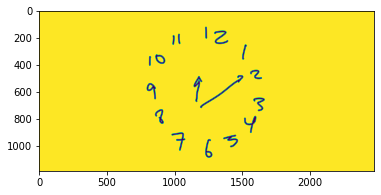

In [31]:
import matplotlib.pyplot as plt

plt.imshow(image_torch)

# Define function

In [36]:
def trim_whitespace(image_torch):    
    left = 0
    while left < image_torch.shape[1] and len(image_torch[:,left].unique()) == 1:
        left += 1

    right = image_torch.shape[1]-1
    while right > 0 and len(image_torch[:,right].unique()) == 1:
        right -= 1

    top = 0
    while top < image_torch.shape[0] and len(image_torch[top,:].unique()) == 1:
        top += 1

    bottom = image_torch.shape[0]-1
    while bottom > 0 and len(image_torch[bottom,:].unique()) == 1:
        bottom -= 1
        
    if top > bottom or left > right:
        return image_torch
        
    return image_torch[top:bottom+1,left:right+1]

In [37]:
import torch
import learn2learn as l2l
import torch.nn as nn

class Lambda(nn.Module):
    def __init__(self, fn):
        super(Lambda, self).__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x)

In [38]:
from torchvision.transforms.functional import crop, resize

def predict(image_torch):
    image_torch_crop = trim_whitespace(image_torch).unsqueeze(0)
    image_torch_resize = resize(image_torch_crop, (256, 256))

    im_tensor = 255 - image_torch_resize.unsqueeze(0)
    kernel_tensor = torch.ones((1, 1, 3, 3))
    torch_result = torch.clamp(torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding ='same', dilation=2), 0, 255)
    torch_result = 255 - torch_result

    device = torch.device('cpu')

    hidden = 64
    adaptation = 10
    ways = 2


    features = torch.nn.Sequential(l2l.nn.Lambda(lambda x: x.view(-1, 1, 256, 256)),
                               l2l.vision.models.ConvBase(hidden=hidden, channels=1, max_pool=False, layers=5),
                               l2l.nn.Lambda(lambda x: x.mean(dim=[2, 3])),
                               Lambda(lambda x: x.view(-1, hidden)))
    features.to(device)
    features.load_state_dict(torch.load(f'adapted_weights/adapted_anil_features_{tests[i]}_2shots_20steps_64hidden.pth'.format(adaptation, hidden), map_location=device))
    head = torch.nn.Linear(hidden, ways)
    head = l2l.algorithms.MAML(head, lr=0.1)
    head.to(device)
    head.load_state_dict(torch.load(f'adapted_weights/adapted_anil_head_{tests[i]}_2shots_20steps_64hidden.pth'.format(adaptation, hidden), map_location=device))
    _, predicted_label = torch.max(head(features(torch_result[0][0])), 1)
    return predicted_label

In [39]:
predict(image_torch)

tensor([1])